## Class Project - Spanish to English Translation using Transformer Architecture

In [1]:
import os
import collections
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import re
from collections import Counter
import string
import sys
import seaborn as sns
import tempfile
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as text
import time
import nltk
from bleu import list_bleu
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import BertTokenizer
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bv

2023-05-23 23:20:16.525650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!date +"%H:%M:%S"

23:20:20


### Data source: https://tatoeba.org/en/downloads

### Read as data frame and keep Spanish and English sentences.

In [3]:
file_path = '/Users/mayurk/downloads/Sentence pairs in Spanish-English - 2023-05-14.tsv'
column_names = ['Column1', 'Spanish', 'Column3', 'English']
df = pd.read_csv(file_path, sep='\t', header=None, names=column_names, encoding='utf-8')
df = df.drop(columns=['Column1', 'Column3'])
df = df.dropna()
df['Spanish'] = df['Spanish'].str.lower()
df['English'] = df['English'].str.lower()
df.shape

(259146, 2)

### Check distribution of sentence length

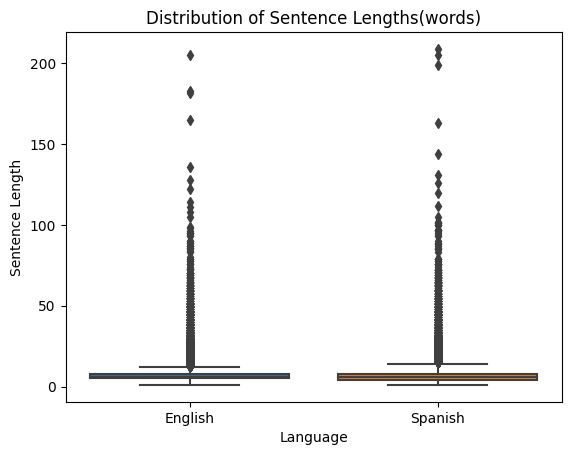

In [4]:
df['english_sentence_length'] = df['English'].apply(lambda x: len(x.split()))
df['spanish_sentence_length'] = df['Spanish'].apply(lambda x: len(x.split()))

sentence_lengths = pd.concat([df['english_sentence_length'], df['spanish_sentence_length']], axis=1)
sentence_lengths.columns = ['English', 'Spanish']

sns.boxplot(data=sentence_lengths)
plt.xlabel('Language')
plt.ylabel('Sentence Length')
plt.title('Distribution of Sentence Lengths(words)')
plt.show()


### Remove duplicate sentences and only keep sentence with length <=128 words.

In [5]:
df_filtered = df.loc[(df['English'].str.split().str.len() <= 128) & (df['Spanish'].str.split().str.len() <= 128)]
df = df_filtered.drop_duplicates()

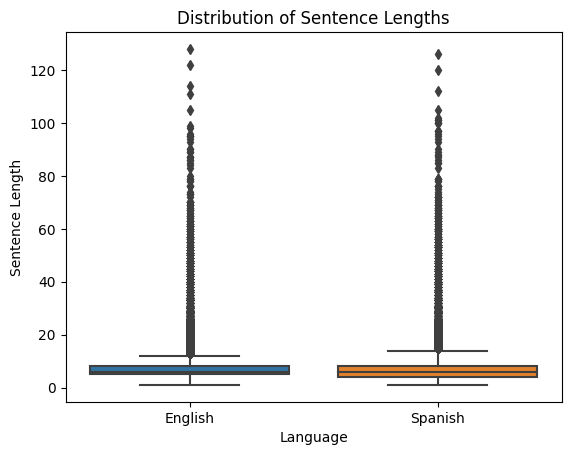

In [6]:
sentence_lengths = pd.concat([df['english_sentence_length'], df['spanish_sentence_length']], axis=1)
sentence_lengths.columns = ['English', 'Spanish']

# Plot box plots
sns.boxplot(data=sentence_lengths)
plt.xlabel('Language')
plt.ylabel('Sentence Length')
plt.title('Distribution of Sentence Lengths')
plt.show()


### Use 100,000 records - Takes upto 7.5 hrs to build model locally for 15 epochs

In [7]:
df=df.head(100000)

### 20 Most frequent Words with more than 5 characters.

In [8]:
english_words = [word for sentence in df['English'] for word in sentence.split() if len(word) > 5]
english_word_frequencies = Counter(english_words)
spanish_words = [word for sentence in df['Spanish'] for word in sentence.split() if len(word) > 5]
spanish_word_frequencies = Counter(spanish_words)

# Get the top 10 most frequent words for each language
top_10_english_words = english_word_frequencies.most_common(20)
top_10_spanish_words = spanish_word_frequencies.most_common(20)

# Create a DataFrame to display the results
english_word_df = pd.DataFrame(top_10_english_words, columns=['Word', 'Frequency'])
spanish_word_df = pd.DataFrame(top_10_spanish_words, columns=['Word', 'Frequency'])

print("Top 20 English Words:")
print(english_word_df)
print()
print("Top 20 Spanish Words:")
print(spanish_word_df)


Top 20 English Words:
         Word  Frequency
0     doesn't       1262
1      didn't       1168
2      should        971
3      people        968
4      please        894
5      always        869
6      you're        634
7      father        612
8      little        597
9     because        587
10     really        539
11    without        533
12     before        531
13    nothing        530
14     better        484
15     mother        476
16     that's        475
17  something        468
18     cannot        466
19     what's        462

Top 20 Spanish Words:
         Word  Frequency
0      estaba       1554
1      cuando       1497
2     siempre        912
3      quiero        869
4      tiempo        807
5      hombre        731
6   demasiado        596
7      hablar        569
8      puedes        555
9      tienes        549
10    mañana.        531
11     parece        531
12     ¿dónde        506
13    después        498
14    trabajo        487
15    tiempo.        481
16   

### Split into Train, Validation and Test dataset

In [9]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=1)
train_df, val_df = train_test_split(train_df, test_size=0.10, random_state=1)

# Display the sizes of the training and testing sets
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))

Training set size: 72000
Validation set size: 8000
Testing set size: 20000


### Build BERT Tokenizer

In [10]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

In [11]:
bert_vocab_args =dict(vocab_size = 8000,reserved_tokens=reserved_tokens,bert_tokenizer_params=bert_tokenizer_params,learn_params={},)

In [12]:
sp_vocab =bv.bert_vocab_from_dataset(tf.data.Dataset.from_tensor_slices(df["Spanish"].values),**bert_vocab_args)
en_vocab = bv.bert_vocab_from_dataset(tf.data.Dataset.from_tensor_slices(df["English"].values),**bert_vocab_args)

2023-05-23 23:20:24.041057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100000]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:21:48.954237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100000]
	 [[{{node Placeholder/_0}}]]


### Sample words from vocabulary

In [13]:
print("Spanish:")
print(sp_vocab[:10])
print(sp_vocab[100:110])
print("English:")
print(en_vocab[:10])
print(en_vocab[100:110])

Spanish:
['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '$', '%', '&', "'"]
['para', 'le', 'mas', 'al', 'te', 'como', 'tu', 'del', 'este', 'si']
English:
['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '$', '%', '&', "'"]
['on', 'not', '##s', 'your', 'can', 'be', 'at', 'don', 'him', 'her']


In [14]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)
write_vocab_file('sp_vocab.dat', sp_vocab)
write_vocab_file('en_vocab.dat', en_vocab)

In [15]:
sp_tokenizer = text.BertTokenizer('sp_vocab.dat', **bert_tokenizer_params)
en_tokenizer = text.BertTokenizer('en_vocab.dat', **bert_tokenizer_params)

### Create function to add start/end tokens before model is trained.

In [16]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

### Test english tokenizer and print tokens/value for one sentence.

In [17]:
token_batch = en_tokenizer.tokenize(train_df["English"])
# Merge the word and word-piece axes -> (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)
for ex in token_batch.to_list():
  print(ex)
  break

[76, 1036, 9, 53, 1393, 1883, 121, 160, 77, 160, 16]


In [18]:
words = en_tokenizer.detokenize(add_start_end(token_batch))
print(str(words[0:1][0].numpy()).strip('[]'))


b'[START]' b'the' b'patient' b"'" b's' b'condition' b'changes' b'from'
 b'day' b'to' b'day' b'.' b'[END]'


### Create String cleanup function and drop the reserved tokens, except for "[UNK]".

In [19]:
def cleanup_text(reserved_tokens, token_txt):
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [20]:
cleanup_text(reserved_tokens, words).numpy()[0]

b"the patient ' s condition changes from day to day ."

### Create Tokenizer Class inherits from tf.Module and create single object with Spanish and English Tokenizer

In [21]:
class myTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [22]:
tokenizers = tf.Module()
tokenizers.sp = myTokenizer(reserved_tokens, 'sp_vocab.dat')
tokenizers.en = myTokenizer(reserved_tokens, 'en_vocab.dat')

#### Test if tokenizer object is working fine(tokenize and detokenize back).

In [23]:
tokenizers.en.detokenize(tokenizers.en.tokenize(['hello chicago!'])).numpy()[0].decode('utf-8')

'hello chicago !'

###  Create Helper Functions for reading dataframe and prepare batches for training, validation and testing.

In [24]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_TOKENS=128

def prepare_batch(sp, en):
    sp = tokenizers.sp.tokenize(sp)
    sp = sp[:, :MAX_TOKENS]
    sp = sp.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  
    en_labels = en[:, 1:].to_tensor()   

    return (sp, en_inputs), en_labels

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((train_df["Spanish"],train_df["English"]))
train_prefetch_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset = tf.data.Dataset.from_tensor_slices((val_df["Spanish"],val_df["English"]))
val_prefetch_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset = tf.data.Dataset.from_tensor_slices((test_df["Spanish"],test_df["English"]))
test_prefetch_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
train_batches = make_batches(train_prefetch_dataset)
val_batches = make_batches(val_prefetch_dataset)

### Check batch  for one record and print tokens

In [27]:
for (sp, en), en_labels in train_batches.take(1):
  break
print(en[0][:10])

2023-05-23 23:22:52.756984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype int64
	 [[{{node Placeholder/_18}}]]
2023-05-23 23:22:52.757374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [72000]
	 [[{{node Placeholder/_1}}]]


tf.Tensor([  2  43   9 136 442 100  83  16   0   0], shape=(10,), dtype=int64)


### Create positional encoding method and plot dimmensions.

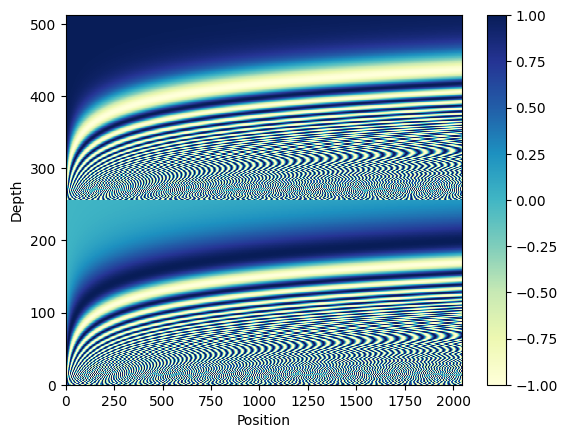

In [28]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(length=2048, depth=512)
plt.pcolormesh(pos_encoding.numpy().T, cmap='YlGnBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

### Create Positional Embedding Class

In [29]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Create Base Attention Class

In [30]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### Create Cross Attention class inherit from Base attention

In [31]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

### Create Global Self Attention class inherit from Base attention

In [32]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### Create Causal Self Attention class inherit from Base attention

In [33]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### Create Feed Forward class with 2 Dense and a Dropout and Normalization Layer

In [34]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

### Create Encoder Layer

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [36]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

### Create Decoder Layer

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [38]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

### Create Transformer class with encode and decoder.

In [39]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Create custom loss and accuracy function to handle masking.

In [40]:
def loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


In [41]:
def accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


### Instantiate the Hyperband tuner and perform hypertuning for number of layers.

In [42]:
import keras_tuner as kt
def build_model(hp):
    transformer_for_hypertune = Transformer(
    num_layers=hp.Int("num_layers",2,5,1),
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)
    
    transformer_for_hypertune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98,epsilon=1e-9),
    loss=loss,
    metrics=[accuracy])
    return transformer

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=2,
    hyperband_iterations=2)

tuner.search(train_batches.take(10),
             validation_data=val_batches.take(10),
             epochs=2,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])
print("The optimal number of layers is:",tuner.get_best_hyperparameters(1)[0].get('num_layers'))

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
The optimal number of layers is: 4


### Custom learning rate

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(128)

Text(0.5, 0, 'Train Step')

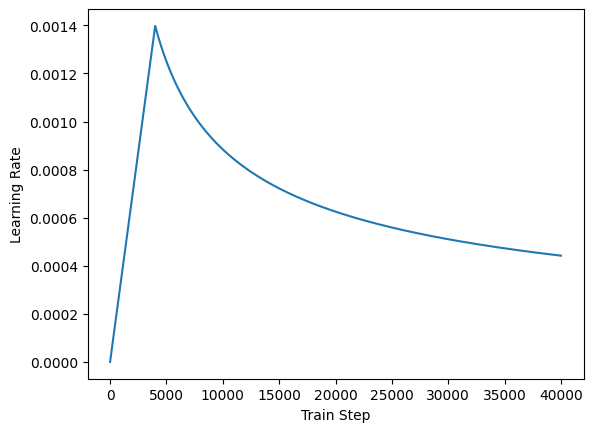

In [45]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Setup Adam optimizer for model training. 

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

### Configure layers, dimmensionality, dff(dense layer width),droput_rate, head and create object of Transformer class

In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)
transformer((sp, en)) # call with sample data for initiate compiler
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3433984   
                                                                 
 decoder (Decoder)           multiple                  5386240   
                                                                 
 dense_16 (Dense)            multiple                  641388    
                                                                 
Total params: 9,461,612
Trainable params: 9,461,612
Non-trainable params: 0
_________________________________________________________________


In [48]:
transformer.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy])

### Train Model

In [49]:
epochs=15
model=transformer.fit(train_batches, epochs=epochs, validation_data=val_batches)

2023-05-23 23:34:31.182789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
2023-05-23 23:34:31.183125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int64
	 [[{{node Placeholder/_14}}]]


Epoch 1/15
1125/1125 [==============================] - ETA: 0s - loss: 5.4475 - accuracy: 0.2763

2023-05-24 00:04:23.499282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype int64
	 [[{{node Placeholder/_18}}]]
2023-05-24 00:04:23.499700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]


1125/1125 [==============================] - 1881s 2s/step - loss: 5.4475 - accuracy: 0.2763 - val_loss: 3.7037 - val_accuracy: 0.4197
Epoch 2/15
1125/1125 [==============================] - 1844s 2s/step - loss: 3.1605 - accuracy: 0.4854 - val_loss: 2.5673 - val_accuracy: 0.5668
Epoch 3/15
1125/1125 [==============================] - 1757s 2s/step - loss: 2.3788 - accuracy: 0.5839 - val_loss: 2.1269 - val_accuracy: 0.6198
Epoch 4/15
1125/1125 [==============================] - 1747s 2s/step - loss: 2.0241 - accuracy: 0.6252 - val_loss: 1.8837 - val_accuracy: 0.6547
Epoch 5/15
1125/1125 [==============================] - 1747s 2s/step - loss: 1.7391 - accuracy: 0.6618 - val_loss: 1.6824 - val_accuracy: 0.6817
Epoch 6/15
1125/1125 [==============================] - 1735s 2s/step - loss: 1.5256 - accuracy: 0.6916 - val_loss: 1.5771 - val_accuracy: 0.6980
Epoch 7/15
1125/1125 [==============================] - 1733s 2s/step - loss: 1.3724 - accuracy: 0.7144 - val_loss: 1.4879 - val_accura

### Create Translator class to perform Spanish to English Translation.

In [50]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.sp.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [51]:
translator = Translator(tokenizers, transformer)

### Print translations on first five sentences in test dataset.

In [52]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Truth":15s}: {ground_truth}',"\n")

In [53]:
for x in range(5):
    sentence = test_df.iloc[x]["Spanish"]
    ground_truth = test_df.iloc[x]["English"]

    translated_text , translated_tokens, attention_weights = translator(tf.constant(sentence))
    print_translation(sentence, translated_text, ground_truth)

Input:         : conducir ebrio es un problema serio.
Prediction     : drunk car is a serious problem .
Truth          : drunk driving is a serious problem. 

Input:         : su redacción estaba libre de fallos.
Prediction     : his essay was failed from failures .
Truth          : her composition was free from mistakes. 

Input:         : en caso de persecución, toda persona tiene derecho a buscar asilo, y a disfrutar de él, en cualquier país.
Prediction     : in case of persecultant , everyone has the right to look up and enjoy it , and enjoy any country , in any country .
Truth          : everyone has the right to seek and to enjoy in other countries asylum from persecution. 

Input:         : eres más inteligente que eso.
Prediction     : you are smarter than that .
Truth          : you are smarter than that. 

Input:         : la historia de su valiente lucha nos conmovió profundamente.
Prediction     : the story of her brave fighting us deeply .
Truth          : the story of his

### Export Translator for future use.

In [54]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [55]:
#translator1 = ExportTranslator(translator)
#tf.saved_model.save(translator1, export_dir='translator')
#translator = tf.saved_model.load('translator')
#print("Model Exported to file !!")

### Calculate BLEU Score for translations on test data for first 100 records. 
**Constraint due to resources**

In [56]:
ref=[]
hyp=[]

for x in range(test_df.head(100).shape[0]):
    sentence = test_df.iloc[x]["Spanish"]
    ground_truth = test_df.iloc[x]["English"]
    translated_text = translator(tf.constant(sentence))[0].numpy().decode("utf-8")
    ref.append(translated_text)
    hyp.append(ground_truth)

In [57]:
bleu_score=list_bleu(ref,hyp)
print("\n","BLEU score:", bleu_score)

[Info] Starting to run this command now: perl /var/folders/k6/wg5923l91_j9h0jwy_r5jbpc0000gn/T/tmp_bleu/multi-bleu-detok.perl /var/folders/k6/wg5923l91_j9h0jwy_r5jbpc0000gn/T/tmp_bleu/ref_dtk0.txt < /var/folders/k6/wg5923l91_j9h0jwy_r5jbpc0000gn/T/tmp_bleu/hyp_dtk0.txt 

 BLEU score: 39.98


### Create Beam Search Function.

In [58]:
def beam_Search(input_sentence,truth_sentence,beam_width):
    encoder_input = tokenizers.sp.tokenize(input_sentence).to_tensor()
    k=beam_width
    max_length=15
    all_candidates = [([2],0)]       #[2] is start of sentence
    for i in tf.range(max_length):         
      new_all_candidates=[] 
      for j in all_candidates:
          original_list,score =j  
          output_array1 = tf.TensorArray(dtype=tf.int32, size=len(original_list))
          for i, num in enumerate(original_list):
            output_array1=output_array1.write(i, tf.constant(num)[tf.newaxis])              
          output = tf.transpose(output_array1.stack())
          predictions = transformer([encoder_input, output], training=False)
          predictions = predictions[:, -1:, :]
          softmax_output = tf.nn.softmax(predictions)
          sorted_tensor = tf.sort(softmax_output, axis=-1, direction='DESCENDING')
          predicted_vec = tf.argsort(softmax_output, axis=-1, direction='DESCENDING')[:, :,:k]
          predicted_prob_vec=sorted_tensor[:,:,:k]    
          temp=tf.reshape(output_array1.stack(), [-1]).numpy()
          for g in range(k):
            if predicted_vec[:,:,g][0].numpy() ==[3]: #[3] is end of sentence
                break
            new_all_candidates.append((np.append(temp,predicted_vec[:,:,g][0]),score+predicted_prob_vec[:,:,g][0]))              
      all_candidates=sorted(new_all_candidates, key=lambda x: x[1], reverse=True)[:k]
    print("Input sentence(sp):",input_sentence)
    print("Truth sentence(en):",truth_sentence,"\n")
    print("Predictions(en):","\n")

    for x,y in all_candidates:
        print(' '.join([tokenizers.en.detokenize(tf.constant(output)[tf.newaxis][tf.newaxis]).numpy()[0].decode('utf-8') for output in x]))
        print("Score:",y.numpy()[0])        

### Run Beam Search with width 5 and print predictions/score.

In [59]:
sentence = "tom pudo decirle a maría la verdad, pero eligió no hacerlo."
truth = "tom could have told mary the truth, but he chose not to."
all_candidates=beam_Search(sentence,truth,5)

Input sentence(sp): tom pudo decirle a maría la verdad, pero eligió no hacerlo.
Truth sentence(en): tom could have told mary the truth, but he chose not to. 

Predictions(en): 

 tom was able to tell mary the truth , but he picked it out .
Score: 12.003317
 tom was able to tell mary the truth , but he tried to do it
Score: 11.981782
 tom was able to tell mary the truth , but he picked out not .
Score: 11.596038
 tom was able to tell mary the truth , but he picked out no .
Score: 11.5602665
 tom was able to tell mary the truth , but he picked it out not
Score: 11.403014


### Visualizing attention weights

In [60]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [61]:
sentence = "tom pudo decirle a maría la verdad, pero eligió no hacerlo."

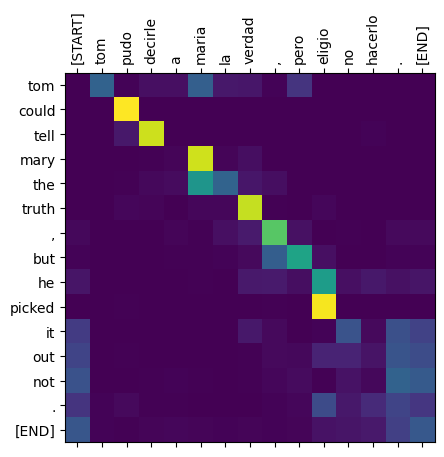

In [62]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.sp.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.sp.lookup(in_tokens)[0]
translated_text , translated_tokens, attention_weights = translator(tf.constant(sentence))
attention =  tf.squeeze(attention_weights, 0)[0]  
plot_attention_head(in_tokens, translated_tokens, attention)

In [63]:
!date +"%H:%M:%S"

06:57:22
